In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pickle
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric as pyg
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.loader as pyg_loader
import pytorch_lightning as pl
import torchmetrics
from torch.utils.data import Dataset
from pathlib import Path
from shutil import copyfile
from tqdm import trange, tqdm
from sklearn.metrics import confusion_matrix

import flygym.util.vision as vision
import flygym.util.config as config
from flygym.util.data import ommatidia_id_map_path

from vision_model import VisualFeaturePreprocessor


In [21]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [22]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

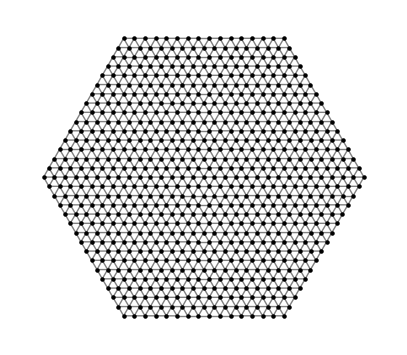

In [24]:
ommatidia_id_map = np.load(ommatidia_id_map_path)
dilation_kernel = np.ones((5, 5), dtype=bool)
edges = set()
node_pos = dict()
for ommatidium_id in range(1, ommatidia_id_map.max() + 1):
    mask_pred = ommatidia_id_map == ommatidium_id
    node_pos[ommatidium_id] = np.mean(np.argwhere(mask_pred), axis=0)
    dilated_mask = ndimage.binary_dilation(mask_pred, dilation_kernel)
    neighbor_ids = np.unique(ommatidia_id_map[dilated_mask])
    for neighbor_id in neighbor_ids:
        if neighbor_id not in [0, ommatidium_id]:
            pair = sorted([ommatidium_id, neighbor_id])
            edges.add(tuple(pair))
graph = nx.from_edgelist(edges)
with open("data/vision/ommatidia_graph.pkl", "wb") as f:
    pickle.dump(graph, f)
pg_graph = pyg.utils.from_networkx(graph)
fig, ax = plt.subplots(figsize=(5, 5))
nx.draw(
    graph,
    pos=node_pos,
    node_size=5,
    width=1,
    node_color="black",
    edge_color="gray",
    ax=ax,
)
ax.set_aspect("equal")
fig.savefig("outputs/ommatidia_graph.pdf", transparent=True)

In [6]:
with open("data/vision/visual_training_data.pkl", "rb") as f:
    visual_training_data_all = pickle.load(f)

/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


[2.98508724 2.06101447]


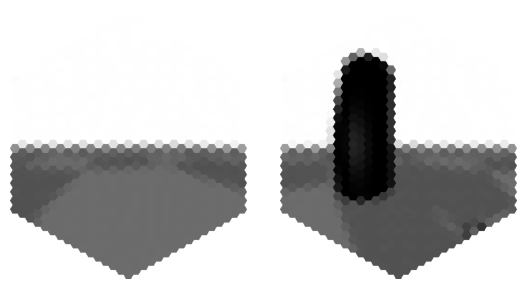

In [7]:
sample_idx = 16
sample = visual_training_data_all[sample_idx]
img_human_l = vision.hex_pxls_to_human_readable(sample["visual_input"][0, :, :])
img_human_r = vision.hex_pxls_to_human_readable(sample["visual_input"][1, :, :])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
axs[0].imshow(img_human_l, cmap="gray", vmin=0, vmax=255)
axs[0].axis("off")
axs[1].imshow(img_human_r, cmap="gray", vmin=0, vmax=255)
axs[1].axis("off")
print(sample["obstacle_position_rel"])

In [8]:
class VisualInputSampleDataset(Dataset):
    fov_lim = np.deg2rad(270 / 2)

    def __init__(
        self, dataset_path, noise_std=0.05, max_dist=10, obj_threshold=50 / 255
    ):
        super().__init__()
        with open(dataset_path, "rb") as f:
            self.dataset = pickle.load(f)
        self.noise_std = noise_std
        self.max_dist = max_dist
        self.obj_threshold = obj_threshold

        # Calculate x-y positions of each ommatidium
        self.coms = np.empty((config.num_ommatidia_per_eye, 2))
        for i in range(config.num_ommatidia_per_eye):
            mask = vision.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        etr = self.dataset[index]
        intensities = etr["visual_input"].astype(np.float32) / 255
        
        # Centroid y position and relative size
        y_pos_li = []
        size_li = []
        for i in range(2):
            obj_mask = intensities[i].max(axis=1) < self.obj_threshold
            obj_mask[~vision.pale_mask] = False
            obj_ommatidia_coords = self.coms[obj_mask]
            obj_size = obj_ommatidia_coords.shape[0]
            if obj_size > 0:
                _, mean_y = obj_ommatidia_coords.mean(axis=0)
                mean_y /= config.raw_img_width_px
                rel_size = obj_size / config.num_ommatidia_per_eye
                rel_size /= (vision.pale_mask.sum() / vision.pale_mask.size)
                if i == 0:
                    mean_y = 1 - mean_y
            else:
                mean_y = 0
                rel_size = 0
            y_pos_li.append(mean_y)
            size_li.append(rel_size)
        azimuth_pos_tensor = torch.tensor(y_pos_li).float()
        rel_size_tensor = torch.tensor(size_li).float()
        
        # Process visual input
        mask = intensities > 0
        intensities_masked = intensities[mask]
        intensities_masked += np.random.normal(
            scale=self.noise_std, size=intensities_masked.shape
        )
        intensities[mask] = intensities_masked
        intensities = np.clip(intensities, 0, 1)
        intensities = torch.tensor(intensities).float()
        graph_left = pg_graph.clone()
        graph_left.x = intensities[0, :]
        graph_right = pg_graph.clone()
        graph_right.x = intensities[1, :]

        # Get target output
        obstacle_position_rel = etr["obstacle_position_rel"]
        direction = np.arctan2(obstacle_position_rel[1], obstacle_position_rel[0])
        distance = np.linalg.norm(obstacle_position_rel)
        angular_pos = torch.tensor([direction, distance / self.max_dist]).float()

        # Is object found?
        mask = np.array([-self.fov_lim < direction < self.fov_lim])
        mask = torch.tensor(mask).int()[0]

        return {
            "intensity": intensities.float(),
            "graph_left": graph_left,
            "graph_right": graph_right,
            "angular_pos": angular_pos,
            "object_found": mask,
            "azimuth": azimuth_pos_tensor,
            "rel_size": rel_size_tensor,
        }

In [9]:
ds = VisualInputSampleDataset("data/vision/visual_training_data.pkl")

In [10]:
def visualize(etr):
    intensities = etr["intensity"].detach().cpu().numpy() * 255
    img_human_l = vision.hex_pxls_to_human_readable(intensities[0, :, :])
    img_human_r = vision.hex_pxls_to_human_readable(intensities[1, :, :])
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
    axs[0].imshow(img_human_l, cmap="gray", vmin=0, vmax=255)
    axs[0].axis("off")
    axs[1].imshow(img_human_r, cmap="gray", vmin=0, vmax=255)
    axs[1].axis("off")
    print(etr["angular_pos"], etr["object_found"])
    print(etr["azimuth"], etr["rel_size"])

tensor([1.9968, 0.6545]) tensor(1, dtype=torch.int32)
tensor([0.8846, 0.8639]) tensor([0.0046, 0.1435])


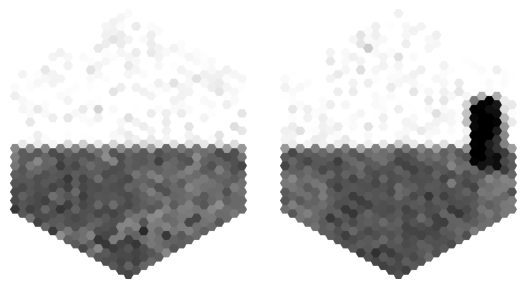

In [11]:
visualize(ds[22])

In [12]:
ds[22]

{'intensity': tensor([[[0.9729, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          ...,
          [0.4672, 0.0000],
          [0.5625, 0.0000],
          [0.3207, 0.0000]],
 
         [[1.0000, 0.0000],
          [0.9449, 0.0000],
          [0.9030, 0.0000],
          ...,
          [0.3665, 0.0000],
          [0.4577, 0.0000],
          [0.4351, 0.0000]]]),
 'graph_left': Data(edge_index=[2, 4140], num_nodes=721, x=[721, 2]),
 'graph_right': Data(edge_index=[2, 4140], num_nodes=721, x=[721, 2]),
 'angular_pos': tensor([1.9968, 0.6545]),
 'object_found': tensor(1, dtype=torch.int32),
 'azimuth': tensor([0.8846, 0.8639]),
 'rel_size': tensor([0.0046, 0.1435])}

In [13]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

train_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [0.8, 0.1, 0.1])
train_loader = pyg_loader.DataLoader(
    train_ds, batch_size=32, shuffle=True, num_workers=8
)
val_loader = pyg_loader.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=8)
test_loader = pyg_loader.DataLoader(
    test_ds, batch_size=32, shuffle=False, num_workers=8
)

In [14]:
model_path = "data/vision/visual_preprocessor.pt"
retrain = True

if retrain:
    model = VisualFeaturePreprocessor()
    logger = pl.loggers.TensorBoardLogger("logs/vision", name="visual_preprocessor")
    checkpoint = pl.callbacks.ModelCheckpoint(save_top_k=5, monitor="val_total_loss")
    trainer = pl.Trainer(
        max_epochs=150,
        deterministic=True,
        logger=logger,
        log_every_n_steps=15,
        enable_progress_bar=True,
    )
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    best_model_path = trainer.checkpoint_callback.best_model_path
    print("Best model:", best_model_path)
    copyfile(best_model_path, model_path)

model = VisualFeaturePreprocessor.load_from_checkpoint(model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


Best model: logs/vision/visual_preprocessor/version_10/checkpoints/epoch=149-step=75000.ckpt


In [15]:
model_cpu = model.to("cpu")
angle_pred_all = np.zeros((len(test_ds)))
dist_pred_all = np.zeros((len(test_ds)))
mask_pred_all = np.zeros((len(test_ds)))
azimuth_pred_all = np.zeros((len(test_ds), 2))
rel_size_pred_all = np.zeros((len(test_ds), 2))
angle_label_all = np.zeros((len(test_ds)))
dist_label_all = np.zeros((len(test_ds)))
mask_label_all = np.zeros((len(test_ds)))
azimuth_label_all = np.zeros((len(test_ds), 2))
rel_size_label_all = np.zeros((len(test_ds), 2))


for i, sample in tqdm(enumerate(test_ds), total=len(test_ds)):
    pred = model_cpu(sample["graph_left"], sample["graph_right"])
    angle_pred_all[i] = pred["angle"].detach().cpu().numpy()
    dist_pred_all[i] = pred["dist"].detach().cpu().numpy()
    mask_pred_all[i] = pred["mask"].detach().cpu().numpy()
    azimuth_pred_all[i, :] = pred["azimuth"].detach().cpu().numpy()
    rel_size_pred_all[i, :] = pred["rel_size"].detach().cpu().numpy()
    angle_label_all[i] = sample["angular_pos"][0].detach().cpu().numpy()
    dist_label_all[i] = sample["angular_pos"][1].detach().cpu().numpy()
    mask_label_all[i] = sample["object_found"].detach().cpu().numpy()
    azimuth_label_all[i, :] = sample["azimuth"].detach().cpu().numpy()
    rel_size_label_all[i, :] = sample["rel_size"].detach().cpu().numpy()

100%|██████████| 2000/2000 [00:03<00:00, 595.84it/s]


In [16]:
angle_label_all

array([-2.30072618, -1.29709864,  2.4008472 , ..., -1.61528742,
        1.45631945,  3.12404776])

In [17]:
metrics = model.get_metrics(
    angle_pred=torch.tensor(angle_pred_all),
    dist_pred=torch.tensor(dist_pred_all),
    mask_pred=torch.tensor(mask_pred_all),
    azimuth_pred=torch.tensor(azimuth_pred_all),
    rel_size_pred=torch.tensor(rel_size_pred_all),
    angle_label=torch.tensor(angle_label_all),
    dist_label=torch.tensor(dist_label_all),
    mask_label=torch.tensor(mask_label_all),
    azimuth_label=torch.tensor(azimuth_label_all),
    rel_size_label=torch.tensor(rel_size_label_all),
)
metrics

{'angle_r2': 0.988272174342651,
 'dist_r2': tensor(0.9695),
 'detection_f1': tensor(0.9288),
 'azimuth_r2': tensor(0.7495),
 'size_r2': tensor(0.8472)}

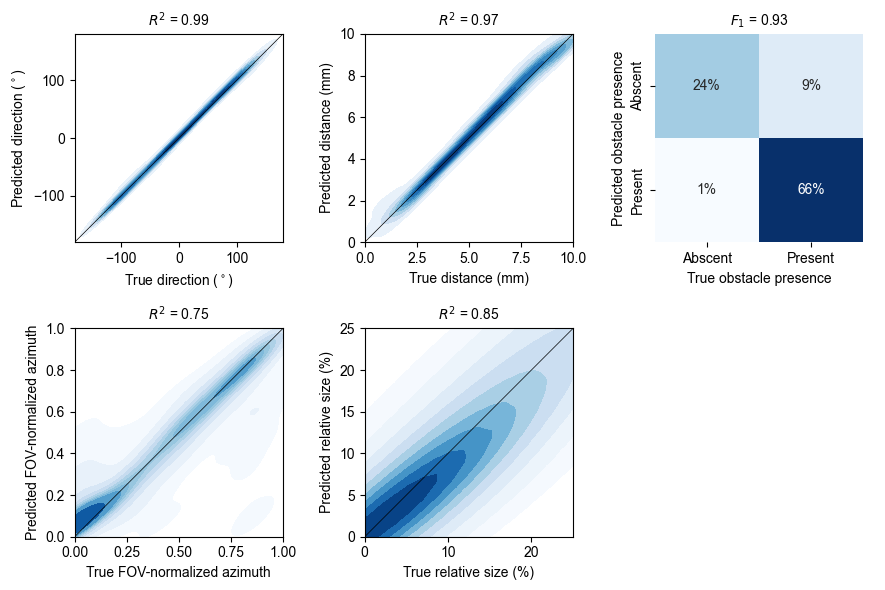

In [18]:
mask = mask_pred_all > 0.5

fig, axs = plt.subplots(2, 3, figsize=(9, 6), tight_layout=True)

ax = axs[0, 0]
sns.kdeplot(
    x=np.rad2deg(angle_label_all[mask]),
    y=np.rad2deg(angle_pred_all[mask]),
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([-180, 180], [-180, 180], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xlabel(r"True direction ($^\circ$)")
ax.set_ylabel(r"Predicted direction ($^\circ$)")
ax.set_title(f"$R^2$ = {np.round(metrics['angle_r2'], 2):.2f}", fontsize=10)

ax = axs[0, 1]
sns.kdeplot(
    x=dist_label_all[mask] * ds.max_dist,
    y=dist_pred_all[mask] * ds.max_dist,
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([0, 10], [0, 10], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel(r"True distance (mm)")
ax.set_ylabel(r"Predicted distance (mm)")
ax.set_title(f"$R^2$ = {np.round(metrics['dist_r2'], 2):.2f}", fontsize=10)

ax = axs[0, 2]
conf_mat = confusion_matrix(mask_pred_all > 0.5, mask_label_all > 0.5)
sns.heatmap(
    conf_mat / conf_mat.sum(), annot=True, fmt=".0%", cmap="Blues", cbar=False, ax=ax
)
ax.set_aspect("equal")
ax.set_xticklabels(["Abscent", "Present"])
ax.set_yticklabels(["Abscent", "Present"])
ax.set_xlabel("True obstacle presence")
ax.set_ylabel("Predicted obstacle presence")
ax.set_title(f"$F_1$ = {np.round(metrics['detection_f1'], 2):.2f}", fontsize=10)

ax = axs[1, 0]
sns.kdeplot(
    x=azimuth_label_all[mask].flatten(),
    y=azimuth_pred_all[mask].flatten(),
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([-180, 180], [-180, 180], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r"True FOV-normalized azimuth")
ax.set_ylabel(r"Predicted FOV-normalized azimuth")
ax.set_title(f"$R^2$ = {np.round(metrics['azimuth_r2'], 2):.2f}", fontsize=10)

ax = axs[1, 1]
sns.kdeplot(
    x=rel_size_label_all[mask].flatten() * 100,
    y=rel_size_pred_all[mask].flatten() * 100,
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([0, 100], [0, 100], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(0, 25)
ax.set_ylim(0, 25)
ax.set_xlabel(r"True relative size (%)")
ax.set_ylabel(r"Predicted relative size (%)")
ax.set_title(f"$R^2$ = {np.round(metrics['size_r2'], 2):.2f}", fontsize=10)

axs[1, 2].axis("off")

fig.savefig("outputs/vision_model_stats.pdf", transparent=True)